# Breach Risk Evaluation Bayesian Network

This Bayesian Network represent a risk evaluation model in the context of a Security Breach. The General Data Protection Regulation (GDPR) in Europe requires companies to report security risks if they are judged likely to impact data subject. 

* Documentation from the ICO: https://ico.org.uk/for-organisations/guide-to-the-general-data-protection-regulation-gdpr/personal-data-breaches/
* Guidelines On Personal data breach notification under Regulation 2016/679 (wp250rev.01): http://ec.europa.eu/newsroom/article29/item-detail.cfm?item_id=612052. Relevant Part: section IV of the Article 29

Different criterias needs to be evaluated in order to come up with a risk evaluation. In this notebook, we use the Twitter internal password leaked in the logs as a scenario: https://blog.twitter.com/official/en_us/topics/company/2018/keeping-your-account-secure.html

* Type of breach: Confidentiality breach
* Nature of the personal data: Passwords
* Sensitivity of the personal data: sensitive
* Volume of personal data: All users
* Ease of identification of individuals: Easy
* Likely attack scenario:
    * An employee / partner with access the passwords in the logs. 
        * Guestimate of the likelihood that somebody would notice that data: 2%
        * Guestimate of the likelihood that someone who noticed the data would try to abuse it: 1%
    * Potential gain could expect from using that data: potentially high if users are using the same passwords somewhere else.
    * Consequences for the employee if caught: really bad
* Special characteristics of the individuals: No medical data or anything that sensitive, but Twitter users could have sensitive private direct messages
* Special characteristics of the data controller: messages, names, phone numbers
* Number of affected individuals: Millions
* General points to identify: 
    * Severity
    * Potential impact
    * Likelihood of these occurring



## Building the Bayes Network

The following Bayes Network was created after analysing the different parameters listed in the scenario. Probabilities are estimates.

In [97]:
structures = [('S', 'V'), ('F', 'V'), ('V', 'R'), 
              ('Q', 'I'), ('I', 'R'), ('E', 'N'), ('N', 'X'), 
              ('A', 'X'), ('P', 'X'), ('W', 'D'), ('X', 'D'), 
              ('B', 'D'), ('K', 'C'), ('Y', 'C'), 
              ('C', 'D'), ('D', 'I')]

variables = {
    'S': {
        'desc': "Sensitivity",
        'legend': {0: 'Low', 1: 'High'},
        'cpd': { 0: 0.1, 1: 0.9} # Passwords are unlikely to not be sensitive (10%), and likely to be sensitive (90%)
    },
    'F': {
        'desc': "Fraud Detection",
        'legend': {0: 'unnoticed', 1: 'Noticed'},
        'cpd': { 0: 0.2, 1: 0.8} # Likely hood that an increase in password abuse would be noticed
    },
    'V': {
        'desc': "Severity",
        'legend': { 0:'Low', 1:'High' },
        'cpd': {
            0: { 'S': { 0: { 'F': { 0: 0.8, 1: 0.4 } }, # Severity is Low if Severity = Low, Fraud = No Increase (80%) or Noticed (40%)
                        1: { 'F': { 0: 0.7, 1: 0.2 } } } }, # Severity is Low if Severity = Low, Fraud = No Increase (70%) or Noticed (20%)
            1: { 'S': { 0: { 'F': { 0: 0.2, 1: 0.6 } }, # Severity is High if Severity = Low, Fraud = No Increase (20%) or Noticed (60%)
                        1: { 'F': { 0: 0.3, 1: 0.8 } } } }, # Severity is High if Severity = High, Fraud = No Increase (30%) or Noticed (80%)
        }
    },
    'Q': {
        'desc': "Quantity",
        'legend': {0: 'Little', 1: 'A lot'},
        'cpd': { 0: 0.3, 1: 0.7} # Small quantity of account leaked (30%), Big quantity of account leaked (70%)
    },
    'E': {
        'desc': "Employees",
        'legend': {0: 'No access', 1: 'Access'},
        'cpd': { 0: 0.45, 1: 0.55} # % Employees who don't have / have access to the logs
    },
    'N':{
        'desc': "Notice",
        'legend': { 0:'Not looking', 1:'Find' },
        'cpd': {
            0: { 'E': { 0: 0.999, 1: 0.01} }, # Probability that an employee don't notice if they have no access, don't notice if they have access
            1: { 'E': { 0: 0.001, 1: 0.99} } # Probability of finding if the employee don't have access / if the employee have access
        }
    },
    'A': {
        'desc': "Ease",
        'legend': {0: 'Hard', 1: 'Easy'},
        'cpd': { 0: 0.3, 1: 0.7} # Correlating the password found with other user information, necessary to exploit the passwords
    },
    'P': {
        'desc': "Speed",
        'legend': {0: 'Slow', 1: 'Fast'},
        'cpd': { 0: 0.8, 1: 0.2} # How fast does the extraction of an exploitable user profile (user/pass) takes?
    },
    'B': {
        'desc': "Noise",
        'legend': {0: 'Noisy', 1: 'Unnoticed'},
        'cpd': { 0: 0.7, 1: 0.3} # How likely that an extraction of the user profile would be noticed by the monitoring services.
    },
    'X': {
        'desc': "Exploitable",
        'legend': { 0:'Low', 1:'High' },
        'cpd': {
            0: { 'N': { 0: { 'A': { 0: { 'P': {0: 0.99, 1: 0.8} },
                                    1: { 'P': {0: 0.7, 1: 0.7} } } },
                        1: { 'A': { 0: { 'P': {0: 0.5, 1: 0.7} },
                                    1: { 'P': {0: 0.7, 1: 0.2} } } } } },
            1: { 'N': { 0: { 'A': { 0: { 'P': {0: 0.01, 1: 0.2} },
                                    1: { 'P': {0: 0.3, 1: 0.3} } } },
                        1: { 'A': { 0: { 'P': {0: 0.5, 1: 0.3} },
                                    1: { 'P': {0: 0.3, 1: 0.8} } } } } }
        }
    },
    'K': {
        'desc': "Job",
        'legend': {0: 'Keep', 1: 'Fired'}, 
        'cpd': { 0: 0.1, 1: 0.9} # How likely that the employee will keep his job if (s)he is discovered extracting the user profiles?
    },
    'Y': {
        'desc': "Criminal Record",
        'legend': {0: 'Ignored', 1: 'Get'},
        'cpd': { 0: 0.05, 1: 0.95} # How likely that the employee will get a criminal record if (s)he is discovered extracting the user profiles?
    },
    'W': {
        'desc': "Reward",
        'legend': {0: 'Low', 1: 'High'},
        'cpd': { 0: 0.6, 1: 0.4} # What is the likelihood of getting a high reward by extrating the user profiles?
    },
    'C': {
        'desc': "Consequences",
        'legend': { 0:'little', 1:'severe' },
        'cpd': {
            0: { 'K': { 0: { 'Y': { 0: 0.9, 1: 0.2 } }, # Likelihood to have little consequences if the employee keeps his job and (don't) get a criminal record
                        1: { 'Y': { 0: 0.4, 1: 0.1 } } } }, # Likelihood to have little consequences if the employee is fired and (don't) get a criminal record
            1: { 'K': { 0: { 'Y': { 0: 0.1, 1: 0.8 } }, # Likelihood to have severe consequences if the employee is not fired and (don't) get a criminal record
                        1: { 'Y': { 0: 0.6, 1: 0.9 } } } }, # Likelihood to have severe consequences if the employee is fired and (don't) get a criminal record
        }
    },
    'D': {
        'desc': "Is Exploited",
        'legend': { 0:'Will exploit', 1:'Will not' }, # How likely it is that an employee will exploit given...
        'cpd': {
            0: { 'W': { 0: { 'X': { 0: { 'B': { 0: { 'C': {0: 0.99, 1: 0.0001} }, # will do it if: low reward, low exploitability, will be detected, little/severe consequence
                                                1: { 'C': {0: 0.9, 1: 0.0005} } } }, # will do it if: low reward, low exploitability, will be detected, little/severe consequence
                                    1: { 'B': { 0: { 'C': {0: 0.98, 1: 0.005} }, # will do it if: low reward, exploitable, will not be detected, little/severe consequence
                                                1: { 'C': {0: 0.85, 1: 0.01} } } } } }, # will do it if: low reward, low exploitability, will be detected, little/severe consequence
                        1: { 'X': { 0: { 'B': { 0: { 'C': {0: 0.8, 1: 0.005} }, # will do it if: high reward, low exploitability, will not be detected, little/severe consequence
                                                1: { 'C': {0: 0.7, 1: 0.008} } } }, # will do it if: high reward, low exploitability, will be detected, little/severe consequence
                                    1: { 'B': { 0: { 'C': {0: 0.4, 1: 0.02} }, # will do it if: high reward, exploitable, will be detected, little/severe consequence
                                                1: { 'C': {0: 0.2, 1: 0.01} } } } } } } }, # will do it if: high reward, exploitable, will not be detected, little/severe consequence
            1: { 'W': { 0: { 'X': { 0: { 'B': { 0: { 'C': {0: 0.01, 1: 0.9999} }, # will not do it if: low reward, low exploitability, will be detected, little/severe consequence
                                                1: { 'C': {0: 0.1, 1: 0.9995} } } }, # will not do it if: low reward, low exploitability, will be detected, little/severe consequence
                                    1: { 'B': { 0: { 'C': {0: 0.02, 1: 0.995} }, # will not do it if: low reward, exploitable, will not be detected, little/severe consequence
                                                1: { 'C': {0: 0.15, 1: 0.99} } } } } }, # will not do it if: if: low reward, low exploitability, will be detected, little/severe consequence
                        1: { 'X': { 0: { 'B': { 0: { 'C': {0: 0.2, 1: 0.995} }, # will not do it if: high reward, low exploitability, will not be detected, little/severe consequence
                                                1: { 'C': {0: 0.3, 1: 0.992} } } }, # will not do it if: high reward, low exploitability, will not be detected, little/severe consequence
                                    1: { 'B': { 0: { 'C': {0: 0.6, 1: 0.98} }, # will not do it if: high reward, exploitable, will be detected, little/severe consequence
                                                1: { 'C': {0: 0.8, 1: 0.99} } } } } } } } # will not do it if: high reward, exploitable, will not be detected, little/severe consequence
        }
    },
    'I': {
        'desc': "Potential Impact", #on users 
        'legend': { 0:'Low', 1:'High' },
        'cpd': {
            0: { 'Q': { 0: { 'D': { 0: 0.02, 1: 0.999 } }, # Low impact if: few users are affected and an employee try to use/not use the passwords
                        1: { 'D': { 0: 0.01, 1: 0.998 } } } }, # Low impact if: a lot of users users are affected and an employee try to use/not use the passwords
            1: { 'Q': { 0: { 'D': { 0: 0.98, 1: 0.001 } }, # High impact if: few users are affected and an employee try to use/not use the passwords
                        1: { 'D': { 0: 0.99, 1: 0.002 } } } }, # High impact if: a lot of users are affected and an employee try to use/not use the passwords
        }
    },
    'R': {
        'desc': "Overall Risk",
        'legend': { 0:'Low', 1:'High' },
        'cpd': {
            0: { 'V': { 0: { 'I': { 0: 0.9, 1: 0.3 } }, # Low risk if: if the severity is low and the potential impact is low/high
                        1: { 'I': { 0: 0.3, 1: 0.1 } } } }, # Low risk if: if the severity is high and the potential impact is low/high
            1: { 'V': { 0: { 'I': { 0: 0.1, 1: 0.7 } }, # high risk if: if the severity is low and the potential impact is low/high
                        1: { 'I': { 0: 0.7, 1: 0.9 } } } }, # high risk if: if the severity is high and the potential impact is low/high
        }
    }
}

## Render the Graphical Representation of the Bayes Network

Everything here is done in the background by the graphviz_helper

In [39]:
%load_ext autoreload
%autoreload 2

from graphviz_helper import render_graph
from graphviz_helper import render_graph_probabilities

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


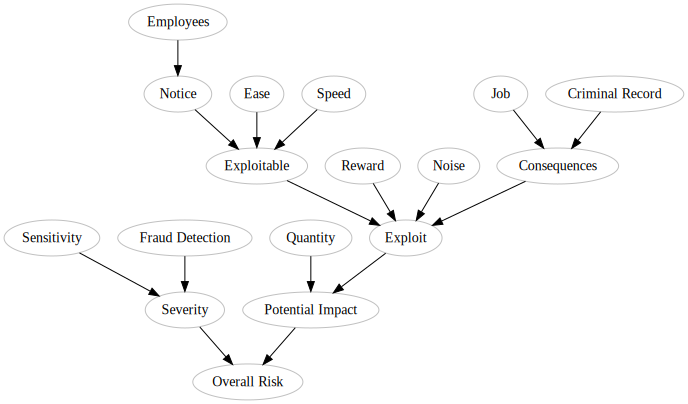

In [59]:
g = render_graph(structures, variables)

g

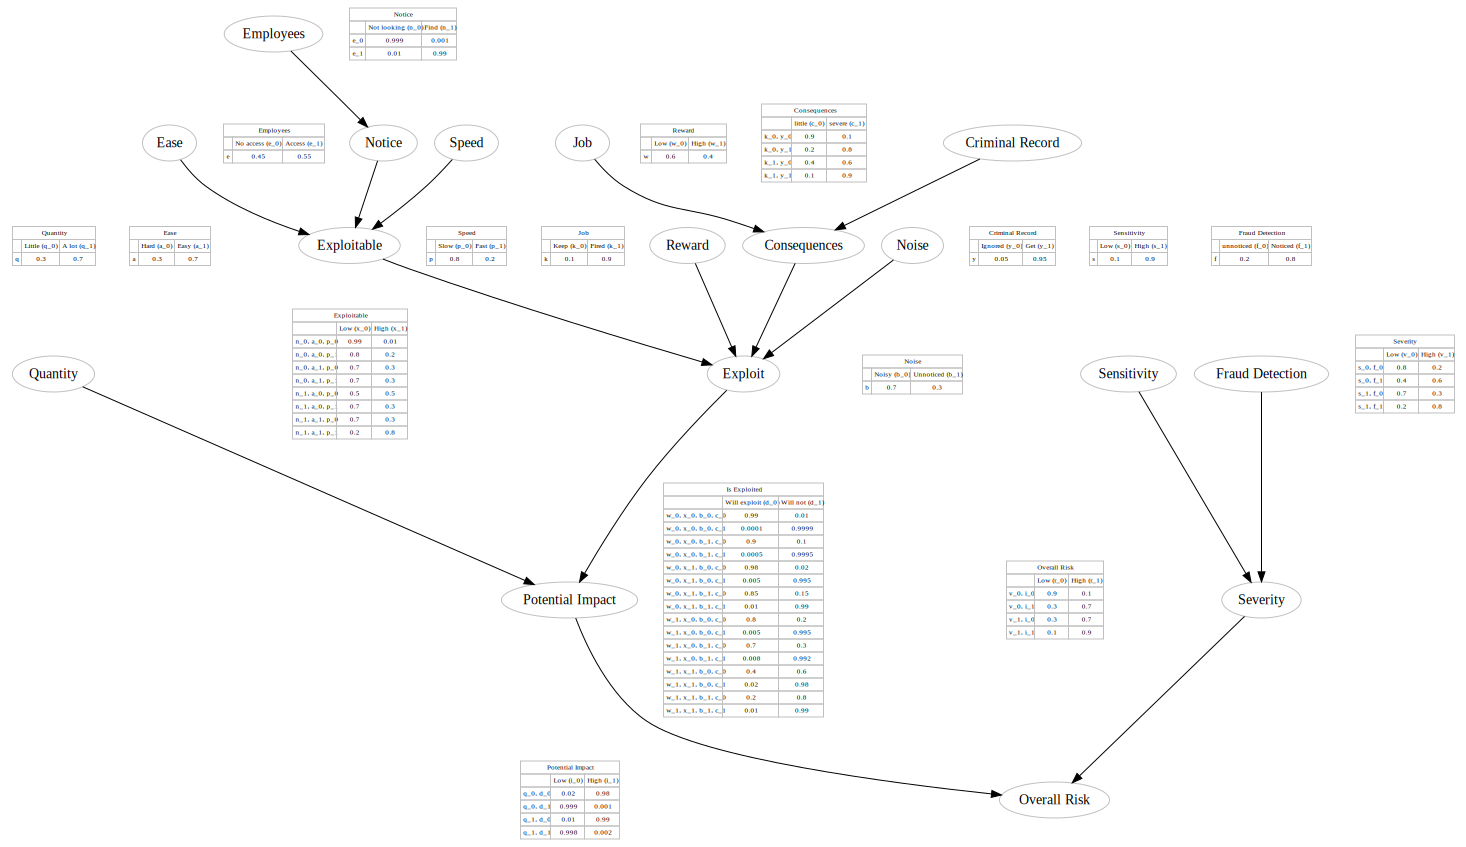

In [98]:
g = render_graph_probabilities(g, variables)

g

In [99]:
from graphviz_helper import build_BayesianModel

# Defining the model structure. We can define the network by just passing a list of edges.
model = build_BayesianModel(structures, variables)

model.check_model()

True

In [77]:
model.get_cpds()

[<TabularCPD representing P(S:2) at 0x1179ff978>,
 <TabularCPD representing P(F:2) at 0x1179ff9e8>,
 <TabularCPD representing P(V:2 | S:2, F:2) at 0x1179ff588>,
 <TabularCPD representing P(Q:2) at 0x1179ff748>,
 <TabularCPD representing P(E:2) at 0x1179ffb00>,
 <TabularCPD representing P(N:2 | E:2) at 0x1179ff2e8>,
 <TabularCPD representing P(A:2) at 0x1179ff0b8>,
 <TabularCPD representing P(P:2) at 0x1179ffac8>,
 <TabularCPD representing P(B:2) at 0x1179ff470>,
 <TabularCPD representing P(X:2 | N:2, A:2, P:2) at 0x1179ffa20>,
 <TabularCPD representing P(K:2) at 0x1179ff860>,
 <TabularCPD representing P(Y:2) at 0x1179ff828>,
 <TabularCPD representing P(W:2) at 0x1179ffcc0>,
 <TabularCPD representing P(C:2 | K:2, Y:2) at 0x1179ff4a8>,
 <TabularCPD representing P(D:2 | W:2, X:2, B:2, C:2) at 0x1179461d0>,
 <TabularCPD representing P(I:2 | Q:2, D:2) at 0x1179464a8>,
 <TabularCPD representing P(R:2 | V:2, I:2) at 0x1179463c8>]

## Printing the CPD for a node

pgmpy allows us to display the probabilities associated with a variable. Here we are looking at the grade. Notice that pgmpy rotates the graph

In [78]:
print(model.get_cpds('R'))

╒═════╤═════╤═════╤═════╤═════╕
│ V   │ V_0 │ V_0 │ V_1 │ V_1 │
├─────┼─────┼─────┼─────┼─────┤
│ I   │ I_0 │ I_1 │ I_0 │ I_1 │
├─────┼─────┼─────┼─────┼─────┤
│ R_0 │ 0.9 │ 0.5 │ 0.3 │ 0.1 │
├─────┼─────┼─────┼─────┼─────┤
│ R_1 │ 0.1 │ 0.5 │ 0.7 │ 0.9 │
╘═════╧═════╧═════╧═════╧═════╛


We can rotate the values to display them in a normal fashion by using the following. However, we lose the column headers and row descriptions.

In [52]:
print(model.get_cpds('R').values.T)
# print(model.get_cardinality('I'))


[[[0.9 0.1]
  [0.6 0.4]]

 [[0.6 0.4]
  [0.2 0.8]]]


In [53]:
# Getting all the local independencies in the network.
model.local_independencies(['V', 'R', 'I', 'D'])

(V _|_ I, X, D, P, R, K, E, C, Y, N, B, Q, W, A | S, F)
(R _|_ X, D, P, K, E, C, Y, N, S, B, F, Q, W, A | I, V)
(I _|_ X, K, P, R, E, C, Y, N, S, V, B, F, W, A | D, Q)
(D _|_ I, P, R, E, Y, N, S, V, F, Q, K, A | B, C, X, W)

In [54]:
# Active trail: For any two variables A and B in a network if any change in A influences the values of B then we say
#               that there is an active trail between A and B.
# In pgmpy active_trail_nodes gives a set of nodes which are affected by any change in the node passed in the argument.
model.active_trail_nodes('R')

{'R': {'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'I',
  'K',
  'N',
  'P',
  'Q',
  'R',
  'S',
  'V',
  'W',
  'X',
  'Y'}}

## What is the overall risk without evidence?

In [55]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)
print(infer.query(['R']) ['R'])

╒═════╤══════════╕
│ R   │   phi(R) │
╞═════╪══════════╡
│ R_0 │   0.4515 │
├─────┼──────────┤
│ R_1 │   0.5485 │
╘═════╧══════════╛


## Knowing what we know about the incident, what is the updated risk?

In [103]:
query_variable = ['V' ,'I', 'R']
evidence = {
    'F': 1, # Abuse would have been detected
    'S': 1, # Severity is high because of the type of data leaked
    'Q': 1, # Quantity of data is high
    'N': 1, # Employees did notice the presence of passwords in the logs
    'A': 0, # Easy to exploit
    'P': 0, # Slow to exploit
    'B': 1, # Trying to get the data would have been detected

}

for q in query_variable:
    if q not in evidence.keys():
        print((infer.query([q], evidence=evidence) [q]))
        print((infer.query([q], evidence=evidence) [q]).values)
    else:
        print("{} is observed as {}".format(q,evidence[q]))

╒═════╤══════════╕
│ V   │   phi(V) │
╞═════╪══════════╡
│ V_0 │   0.6000 │
├─────┼──────────┤
│ V_1 │   0.4000 │
╘═════╧══════════╛
[0.6 0.4]
╒═════╤══════════╕
│ I   │   phi(I) │
╞═════╪══════════╡
│ I_0 │   0.1845 │
├─────┼──────────┤
│ I_1 │   0.8155 │
╘═════╧══════════╛
[0.18449095 0.81550905]
╒═════╤══════════╕
│ R   │   phi(R) │
╞═════╪══════════╡
│ R_0 │   0.5027 │
├─────┼──────────┤
│ R_1 │   0.4973 │
╘═════╧══════════╛
[0.50272692 0.49727308]


## Predicting values from new data points

Let's say that we don't care about the probability itself, we just want to know which is the most likely outcome for each variable.

Predicting values from new data points is quite similar to computing the conditional probabilities. We need to query for the variable that we need to predict given all the other features. The only difference is that rather than getting the probabilitiy distribution we are interested in getting the most probable state of the variable.

In pgmpy this is known as MAP query. 

Here's an example if we don't have evidence:

In [90]:
# What is the most probable value for the variables `query_variable`, if we don't provide evidence?
infer.map_query(query_variable)

{'I': 1, 'R': 1, 'V': 1}

Same query, but with evidences:

In [91]:
# What is the most probable value for the variables `query_variable`, given evidences `evidence`?
infer.map_query(query_variable, evidence=evidence)

{'I': 1, 'R': 0, 'V': 0}